In [1]:
import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product
import torch.nn.functional as F

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'

In [2]:
from utils import *
from embed import *

models = ["wr-4-8", "allcnn-96-144", "fc-1024-512-256-128"]
opts = ["adam", "sgdn", "sgd"]

In [3]:
T = 45000
ts = []
for t in range(T):
    if t < T//10:
        if t % (T//100) == 0:
            ts.append(t)
    else:
        if t % (T//10) == 0 or (t == T-1):
            ts.append(t)
ts = np.array(ts)
tmap = {i:ts[i] for i in range(len(ts))}
pts = np.concatenate([np.arange(ts[i], ts[i+1], (ts[i+1]-ts[i]) // 5) for i in range(len(ts)-1)])
N = len(pts)

## Bhat vs InPCA

In [29]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':[200, 400], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models, 'opt':opts},
           avg_err=True, keys=['yh'], drop=False, probs=True)
d = avg_model(d, groupby=['m', 'opt', 't', 'bs'], probs=True, get_err=True, keys=['yh'],
              update_d=True, compute_distance=False, dev='cuda')['d']
d = interpolate(d, ts, pts, columns=['seed', 'm', 'opt', 'avg', 'bs'], keys=['yh'], dev='cuda')

KeyboardInterrupt: 

In [ ]:
loc = 'inpca_results'
fn = 'yh_new_interpolate_with_avg'
L = th.load(os.path.join(loc,'w_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

In [ ]:
P = np.eye(L.shape[0]) - 1.0/L.shape[0]
W = -P @ L @ P / 2 
n = len(W)
r = proj_(W, n, 500)

Projecting


In [ ]:
df = pd.DataFrame(np.vstack([np.abs(r['e']), np.sign(r['e'])]).T, columns=['value', 'sign'])

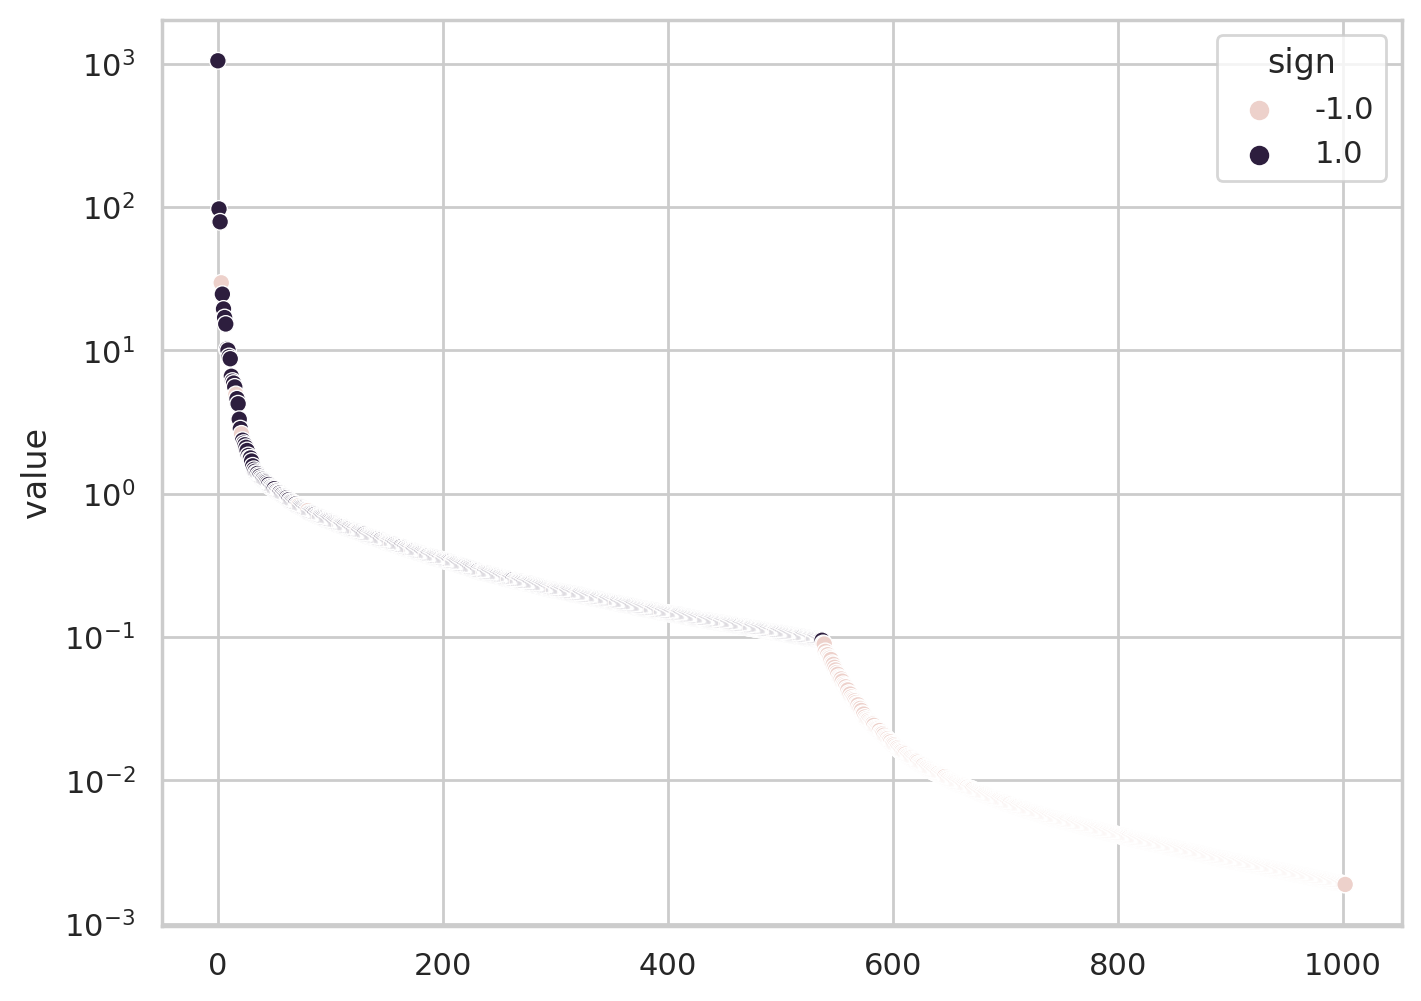

In [ ]:
# plt.plot(df['value'])
ax = sns.scatterplot(data=df, x=df.index, y='value', hue='sign')
ax.set_yscale('log')

In [ ]:
from distance import dbhat, dinpca

dists = []
k = 'yh'
m = models[0]
o = opts[0]
seeds = dc['seed'].unique()
L = th.Tensor(L)
l = th.norm(L).item()
avg_fnorm = []
for ne in np.concatenate([np.arange(10, 50, 10), np.arange(50, 200, 50), np.arange(200, 1000, 300)]):
    print(ne)
    if ne > 100:
        di = th.zeros_like(L)
        for k in range(ne // 100+1):
            xi = th.Tensor(r['xp'][:, k*100:min((k+1)*100, ne)])
            sgn = th.Tensor(np.sign(r['e'][k*100:min((k+1)*100, ne)]))
            di += dinpca(xi, xi, sgn, dev='cpu')
    else:
        di = dinpca(th.Tensor(r['xp'][:, :ne]), th.Tensor(r['xp'][:, :ne]), th.Tensor(np.sign(r['e'][:ne])), dev='cpu')
    avg_fnorm.append(dict(fnorm=th.norm(di.cpu()-L).item() / l, ne=ne))
#     for s1 in range(len(seeds)):
#         for s2 in range(s1+1, len(seeds)):
#             ne = int(ne)
#             i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s1]}")
#             i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s2]}")
#             di = dinpca(th.Tensor(r['xp'][i1, :ne]), th.Tensor(r['xp'][i2, :ne]), th.Tensor(np.sign(r['e'][:ne])))
# #             di = di + th.Tensor(cmean[:, i1]).cuda() + th.Tensor(rmean[i2, :]).cuda()
# #             db = dbhat(th.Tensor(np.stack(d.iloc[i1][k])), th.Tensor(np.stack(d.iloc[i2][k])))
#             db = th.Tensor(w)[:, i1][i2].to(dev)
#             avg_fnorm.append(dict(fnorm=th.norm(di-db).item(), ne=ne, label=(seeds[s1], seeds[s2])))
#     #         dists.append(dict(dist=di.cpu(), distf='inpca', s1=seeds[s1], s2=seeds[s2]))
#     #         dists.append(dict(dist=db.cpu()**2, distf='bhat', s1=seeds[s1], s2=seeds[s2]))
dists = pd.DataFrame(dists)

10
20
30
40
50
100
150
200
500
800


<AxesSubplot:xlabel='ne', ylabel='fnorm'>

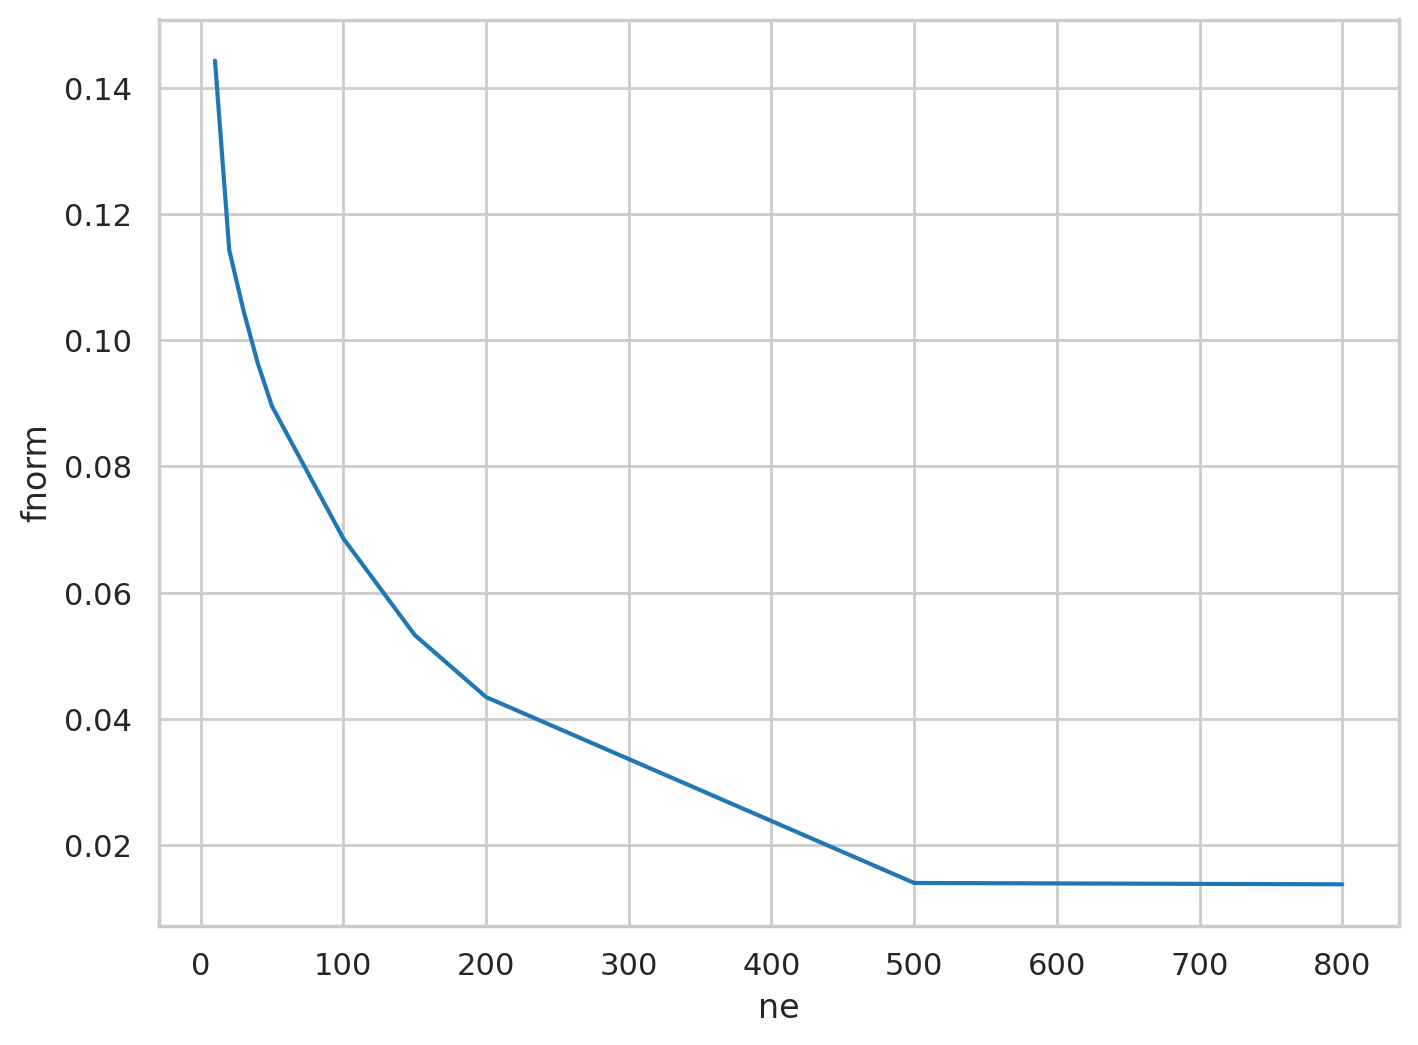

In [ ]:
df = pd.DataFrame(avg_fnorm)
sns.lineplot(data=df, x='ne', y='fnorm')

## Distance to avg

In [ ]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs': [200], 'aug': [True], 'wd': [0.0], 'bn': [True], 'm': models, 'opt': opts},
           avg_err=True, drop=True, probs=True)

# d = avg_model(d, groupby=['m', 'opt', 't'], probs=True, get_err=True,
#               update_d=True, compute_distance=False, dev='cuda')['d']
# d = interpolate(d, ts, pts, columns=['seed', 'm', 'opt', 'avg'], keys=['yh'], dev='cuda')


Index(['index', 'seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh',
       'f', 'e', 'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1800


In [ ]:
dists = []
for s in np.concatenate([[0], np.arange(0.05, 0.5, 0.05)]):
    k = 'yh'
    o = opts[0]
    m = models[0]
    i1 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs==200 & avg==True")
    for seed in d['seed'].unique():
        if seed < 0:
            continue
        i2 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs==200& seed=={seed}")
        kdist = dp2t(th.Tensor(np.stack(d.iloc[i1][k].values)), th.Tensor(np.stack(d.iloc[i2][k].values)), 
                     dys=th.ones(95).cuda(), s=s)
        if s == 0:
            kdist = dp2t(th.Tensor(np.stack(d.iloc[i1][k].values)), th.Tensor(np.stack(d.iloc[i2][k].values)), 
                         use_min=True)
        for i in range(N):
            dists.append(dict(dist=kdist[i].item(),
                              m=m, opt=o, 
                              t=pts[i], key=k, seed=seed, s=s))

Text(0.5, 1.0, 'weight $\\propto exp(-d^2/2s^2) * dy$')

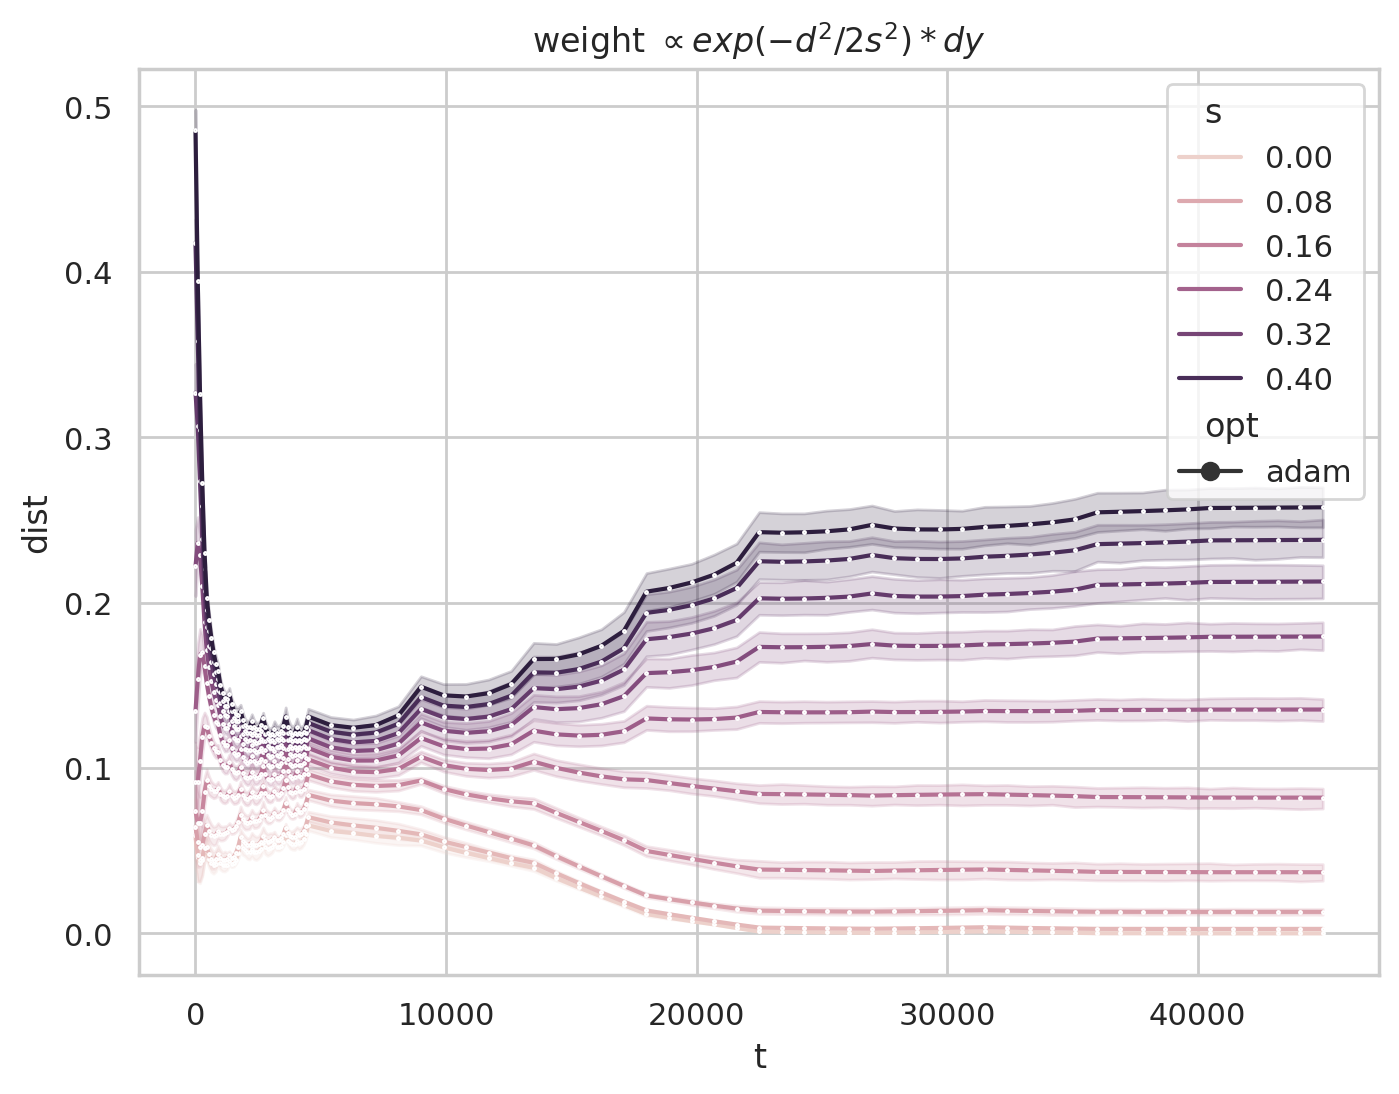

In [ ]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('weight $\propto exp(-d^2/2s^2) * dy$')

Text(0.5, 1.0, 'weight $\\propto exp(-d^2/2s^2) * dt$')

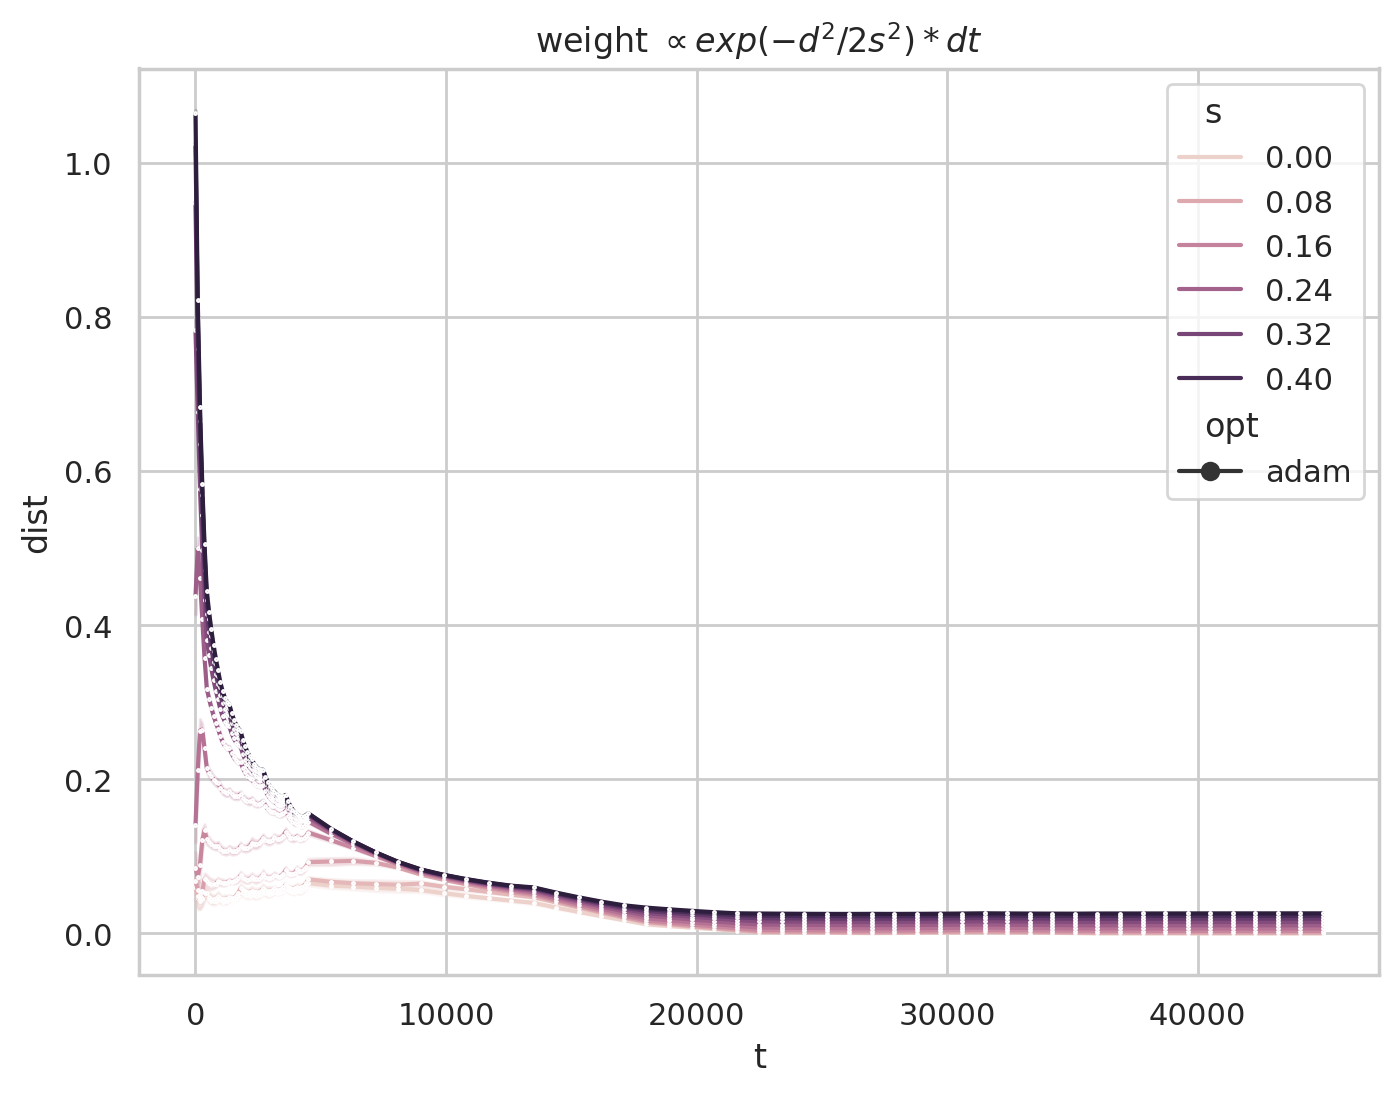

In [ ]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('weight $\propto exp(-d^2/2s^2) * dt$')

Text(0.5, 1.0, 'weight $\\propto exp(-d^2/2s^2)$')

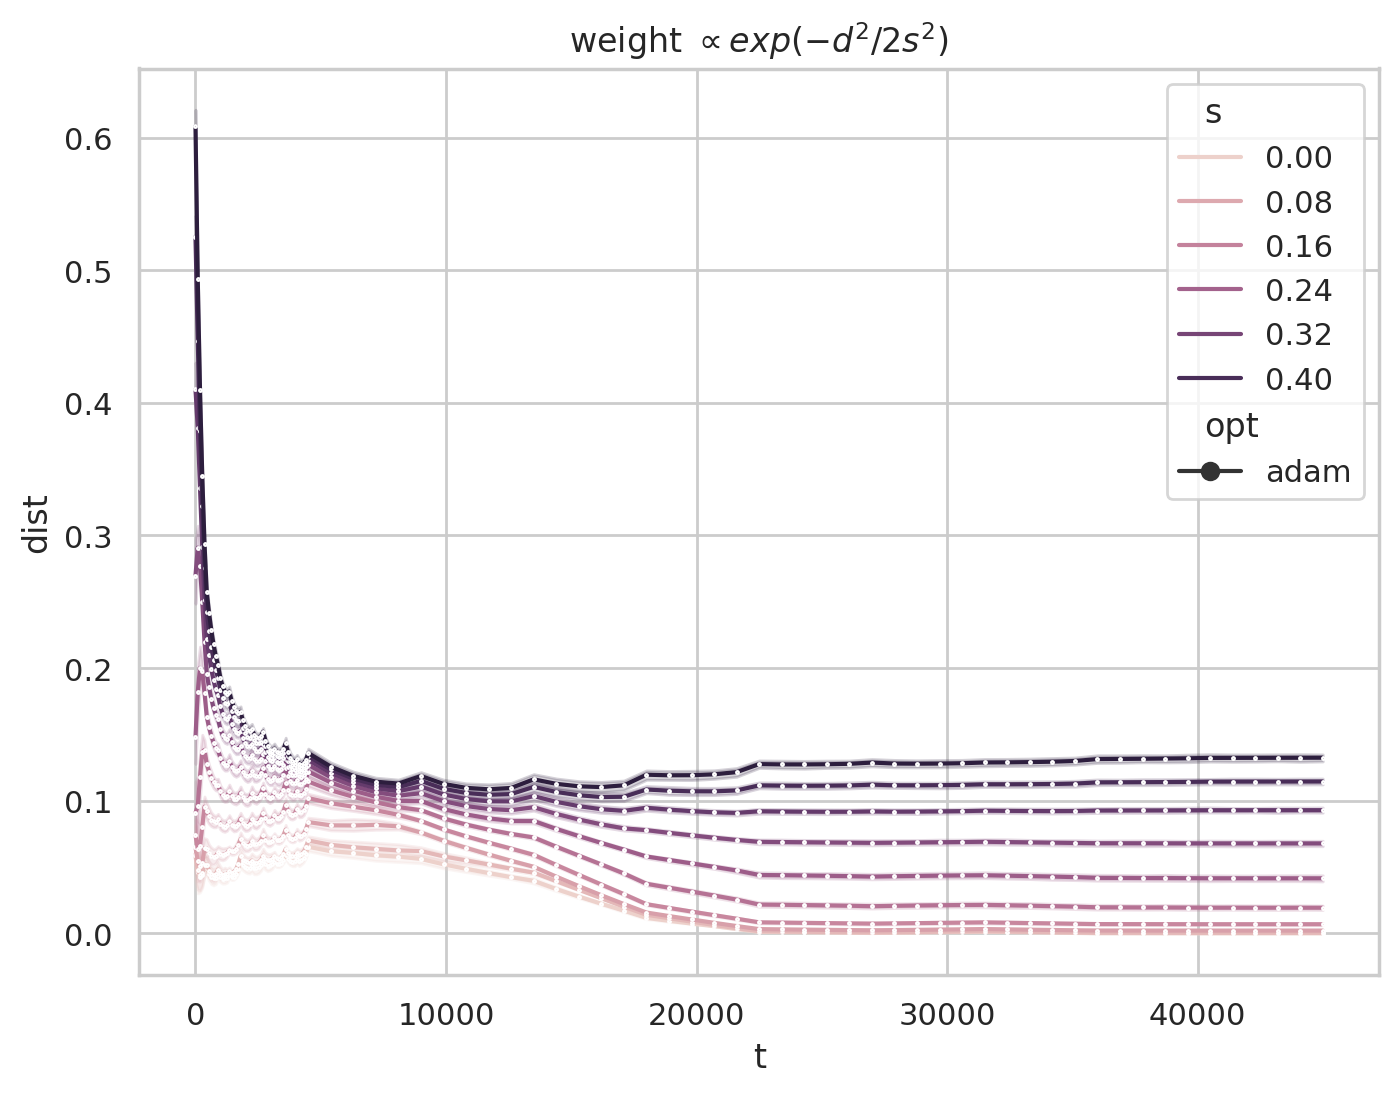

In [ ]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('weight $\propto exp(-d^2/2s^2)$')

In [ ]:
dists = []
k = 'yh'
for bs in [200, 400]:
    for o in opts:
        for m in models:
            
            i1 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs=={bs} & avg==True")
            for seed in d['seed'].unique():
                if seed < 0:
                    continue
                i2 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs=={bs} & seed=={seed}")
                kdist = dp2t(th.Tensor(np.stack(d.iloc[i1][k].values)), 
                             th.Tensor(np.stack(d.iloc[i2][k].values)), s=0.05)
                for i in range(N):
                    dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                      t=pts[i], key=k, seed=seed, s=0.05, bs=bs))

Text(0.5, 1.0, 'distance to average model, bs==200, s==0.05')

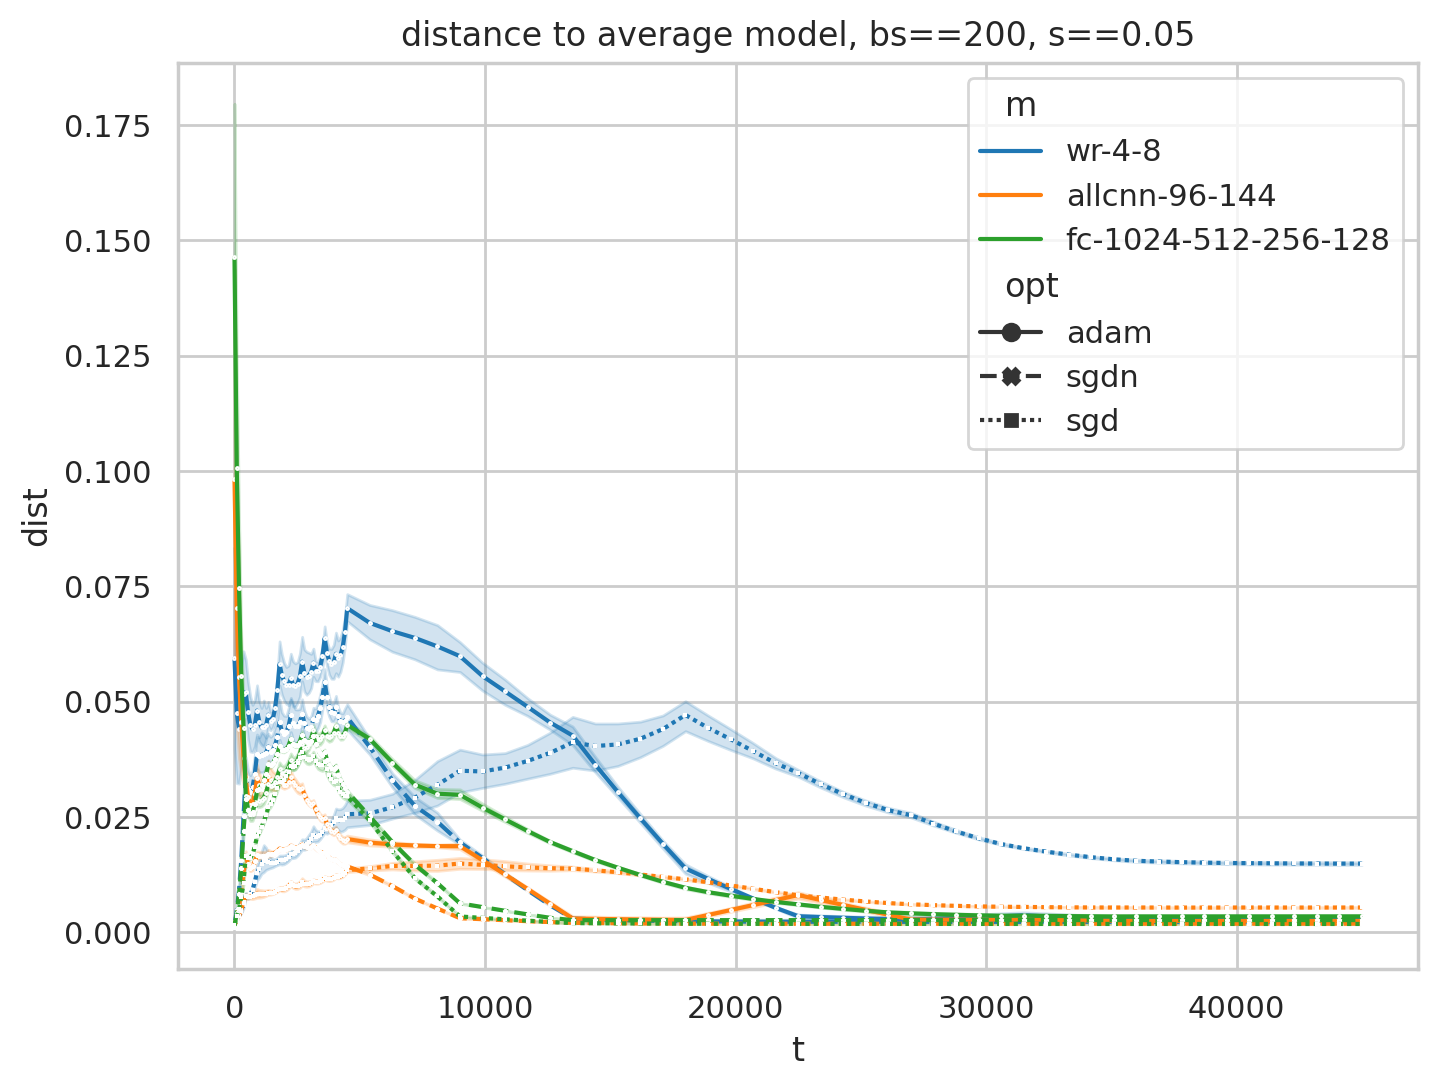

In [ ]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"bs==200")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model, bs==200, s==0.05')

Text(0.5, 1.0, 'distance to average model, bs==200')

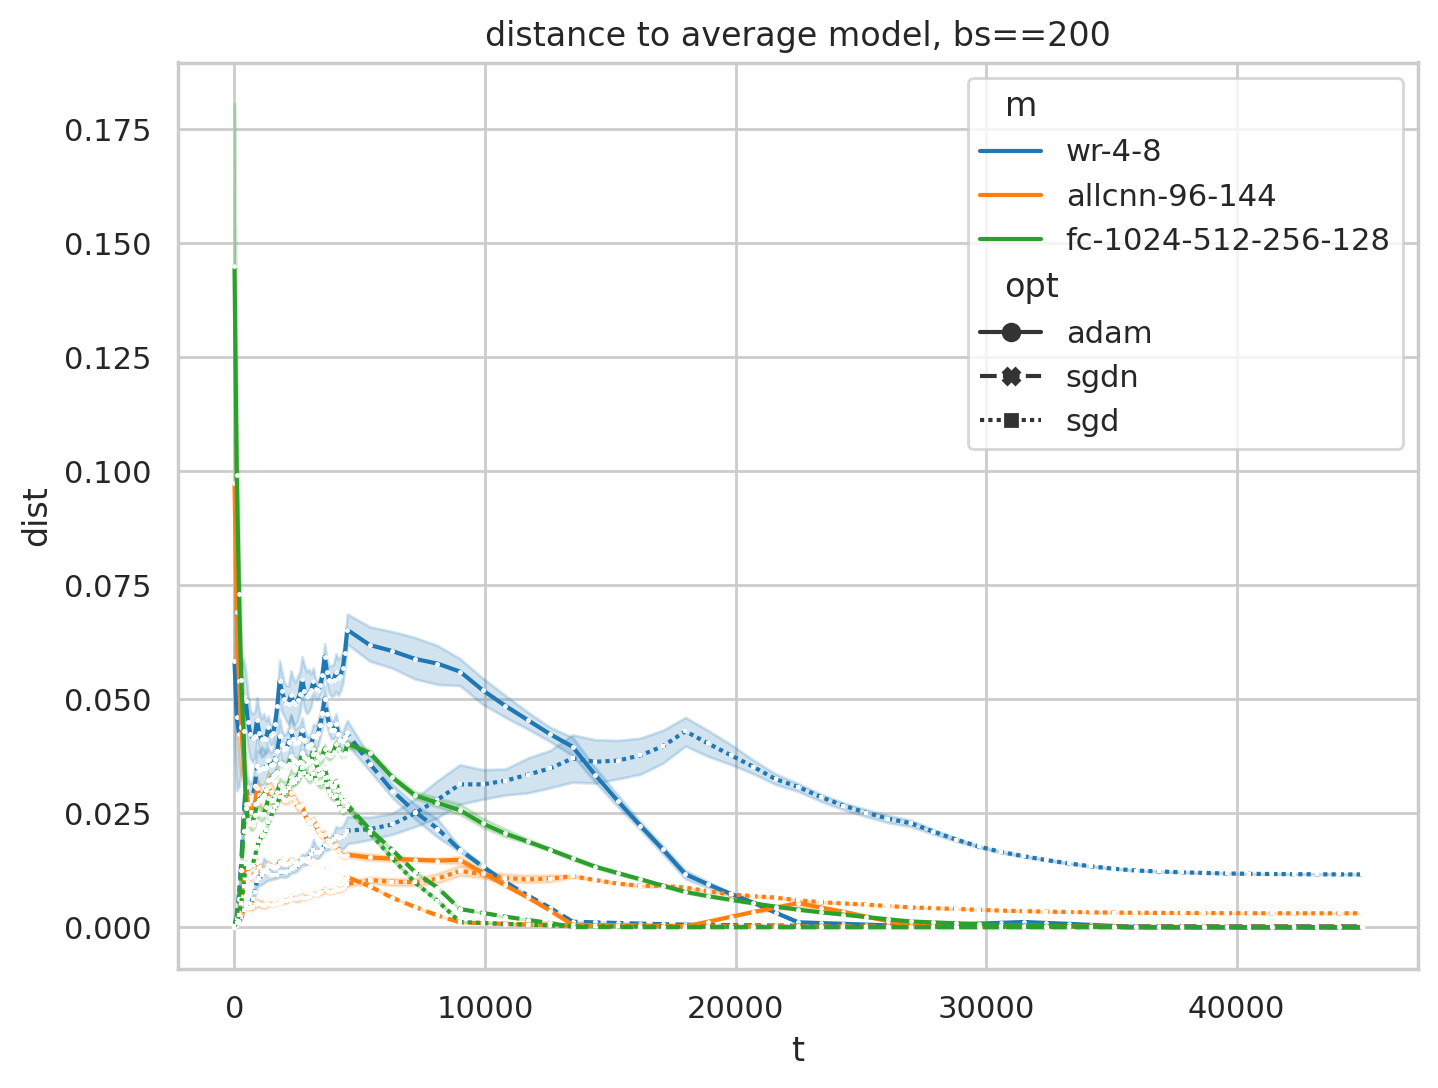

In [ ]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"bs==200")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model, bs==200')

Text(0.5, 1.0, 'distance to average model, bs=400')

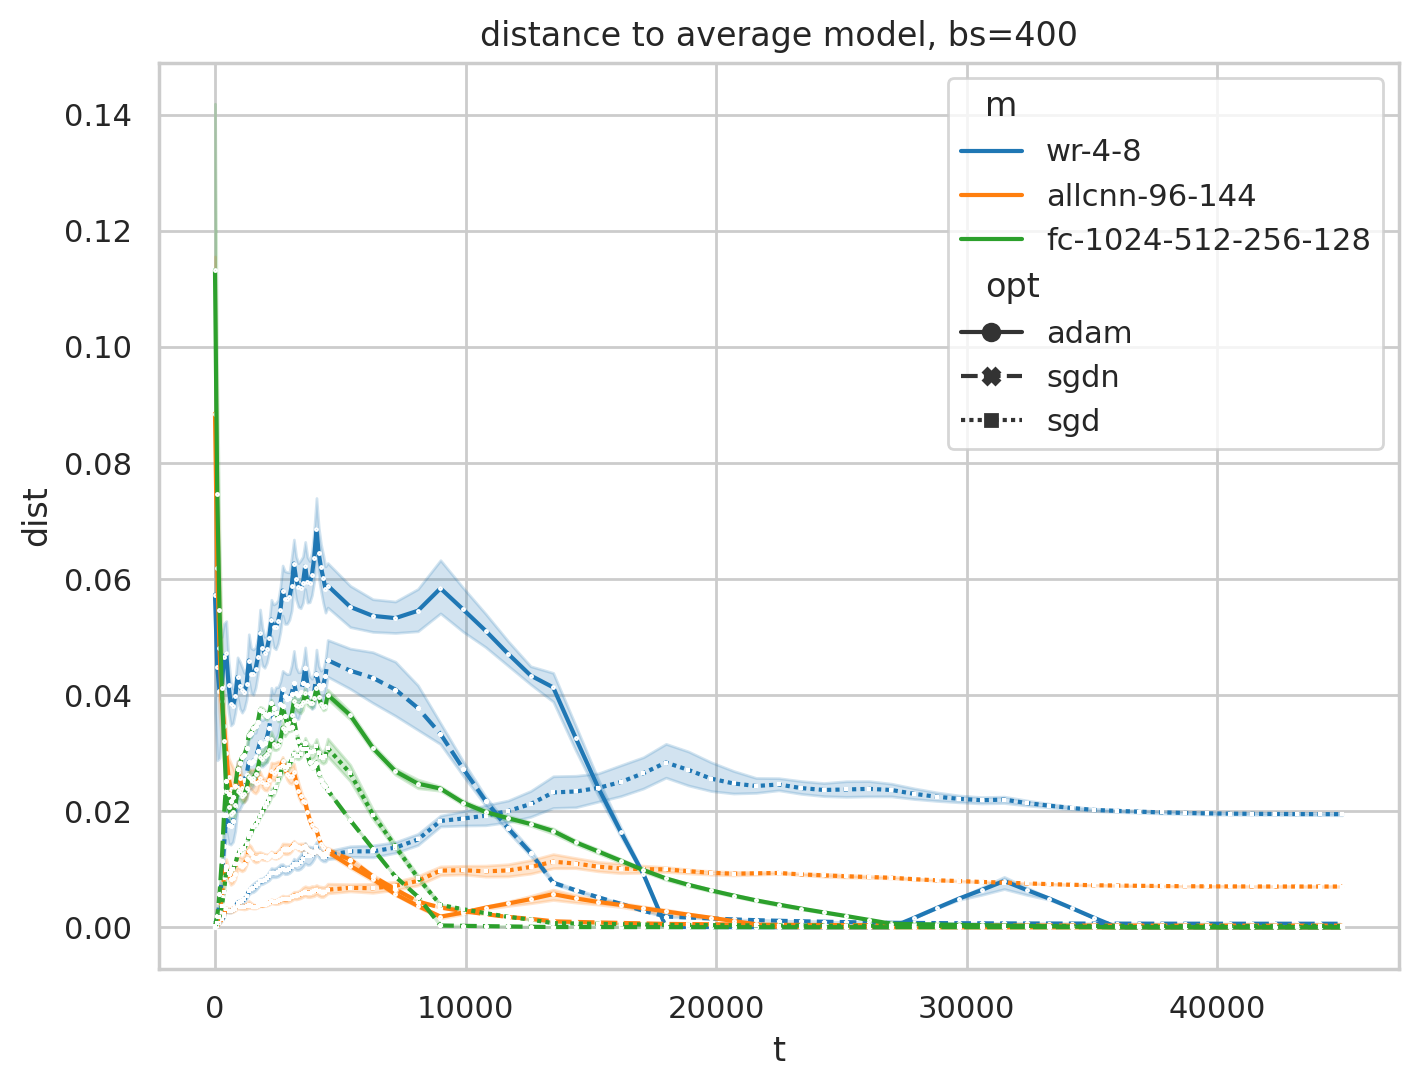

In [ ]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"bs==400")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model, bs=400')

## Pairwise Distance

In [ ]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':[200], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models, 'opt':opts},
           avg_err=True, drop=True, probs=True)

d = avg_model(d, groupby=['m', 'opt', 't'], probs=True, get_err=True, 
              update_d=True, compute_distance=False, dev='cuda')['d']
# d = interpolate(d, ts, pts, columns=['seed', 'm', 'opt', 'avg'], keys=['yh'], dev='cuda')

Index(['index', 'seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh',
       'f', 'e', 'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1800


In [5]:
def plot_pairwise_dist(dists, configs, cconds=[lambda x: True], 
                    rconds=[lambda x: True], sortby=1, mean=False, 
                    xblock_size=10, yblock_size=1, annot=False):
    cidxs = []
    ridxs = []
    columns = []
    rows = []
    if cconds or rconds:
        for (i, c) in enumerate(configs):
            if cconds and all(f[k] for f in cconds):
                cidxs.append(i)
                columns.append(c)
            if rconds and all(f[k] for f in rconds):
                ridxs.append(i)
                rows.append(c)
    else:
        cidxs, ridxs = range(len(configs)), range(len(configs))
        columns, rows = configs, configs
    cidxs, ridxs = np.array(cidxs), np.array(ridxs)
    columns, rows = np.stack(columns), np.stack(rows)
    ridxs = np.lexsort(rows[:, sortby:sortby+1].T)
    cidxs = cidxs[np.lexsort(columns[:, sortby:sortby+1].T)]
    columns = columns[np.lexsort(columns[:, sortby:sortby+1].T), :]
    ridxs = ridxs[np.lexsort(rows[:, sortby:sortby+1].T)]
    rows = rows[np.lexsort(rows[:, sortby:sortby+1].T), :]

    didxs=dists[:, cidxs][ridxs]
    
    if mean:
        avg_dists = F.conv2d(th.Tensor(didxs).unsqueeze(0).unsqueeze(0), 
                             weight=th.ones(1,1, xblock_size, yblock_size)/(xblock_size*yblock_size), stride=(xblock_size, yblock_size))
        ax = sns.heatmap(pd.DataFrame(avg_dists.squeeze().numpy(), 
                                 columns=columns[::xblock_size], index=rows[::yblock_size]), annot=annot, fmt='.2g')
    else:
        ax = sns.heatmap(pd.DataFrame(didxs, columns=columns, index=rows), 
                    xticklabels=xblock_size, yticklabels=yblock_size, annot=annot, fmt='.2g')
    return ax

In [7]:
conds = [lambda x: len(x[-1]) > 0]

In [52]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length'
dists, symd, configs, groups = th.load(os.path.join(loc, f'{fname}.p')).values()

/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


[[200 'allcnn-96-144' 'adam' 42 (-1, 0)]
 [200 'allcnn-96-144' 'adam' 43 (-1, 0)]
 [200 'allcnn-96-144' 'adam' 44 (-1, 0)]
 [200 'allcnn-96-144' 'adam' 45 (-1, 0)]
 [200 'allcnn-96-144' 'adam' 46 (-1, 0)]
 [200 'allcnn-96-144' 'adam' 47 (-1, 0)]
 [200 'allcnn-96-144' 'adam' 48 (-1, 0)]
 [200 'allcnn-96-144' 'adam' 49 (-1, 0)]
 [200 'allcnn-96-144' 'adam' 50 (-1, 0)]
 [200 'allcnn-96-144' 'adam' 51 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 42 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 43 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 44 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 45 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 46 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 47 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 48 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 49 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 50 (-1, 0)]
 [200 'allcnn-96-144' 'sgd' 51 (-1, 0)]
 [200 'allcnn-96-144' 'sgdn' 42 (-1, 0)]
 [200 'allcnn-96-144' 'sgdn' 43 (-1, 0)]
 [200 'allcnn-96-144' 'sgdn' 44 (-1, 0)]
 [200 'allcnn-96-144' 'sgdn' 45 (-1, 0)]
 [200 'allcnn-96-144' 'sgd

Text(0.5, 1.0, 'dist_0.0_mean_length_True')

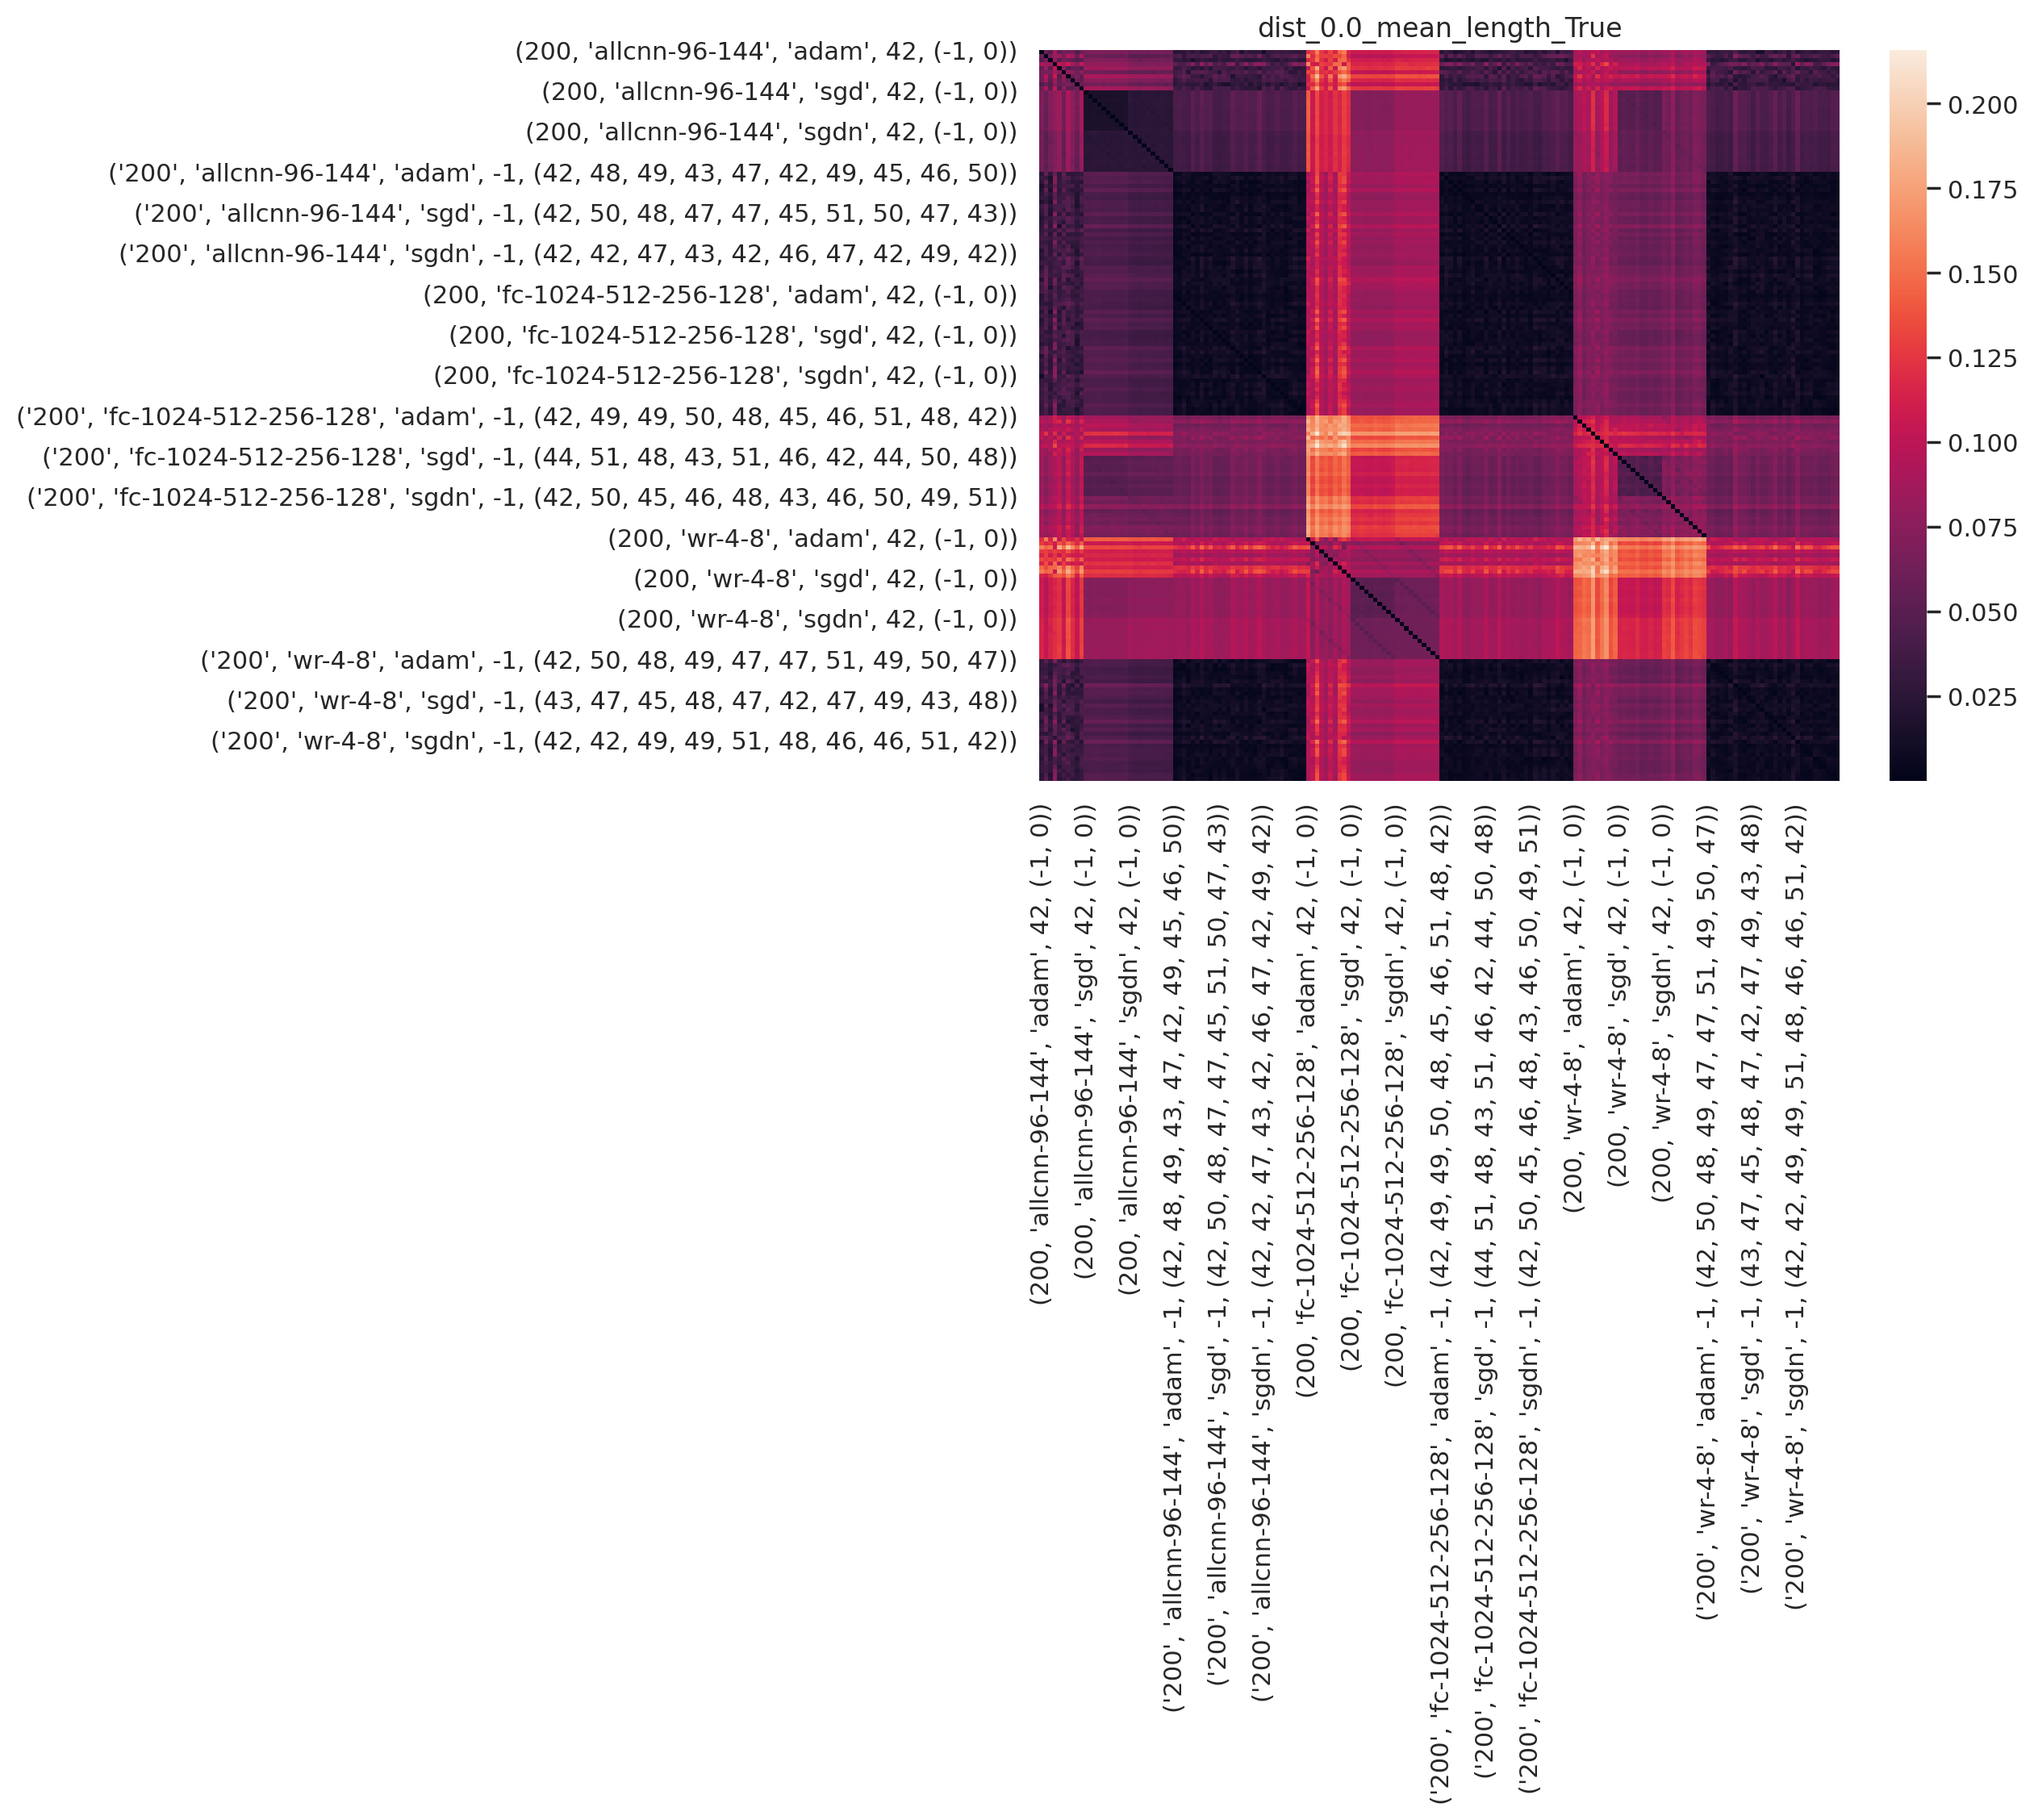

In [6]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length_True'
dists, symd, configs, groups = th.load(
    os.path.join(loc, f'{fname}.p')).values()
ax = plot_pairwise_dist(symd, configs, 
    cconds=[lambda x: ], mean=False, sortby=1, xblock_size=10, yblock_size=10, annot=False)
ax.set_title(fname)


Text(0.5, 1.0, 'dist_0.0_mean_length')

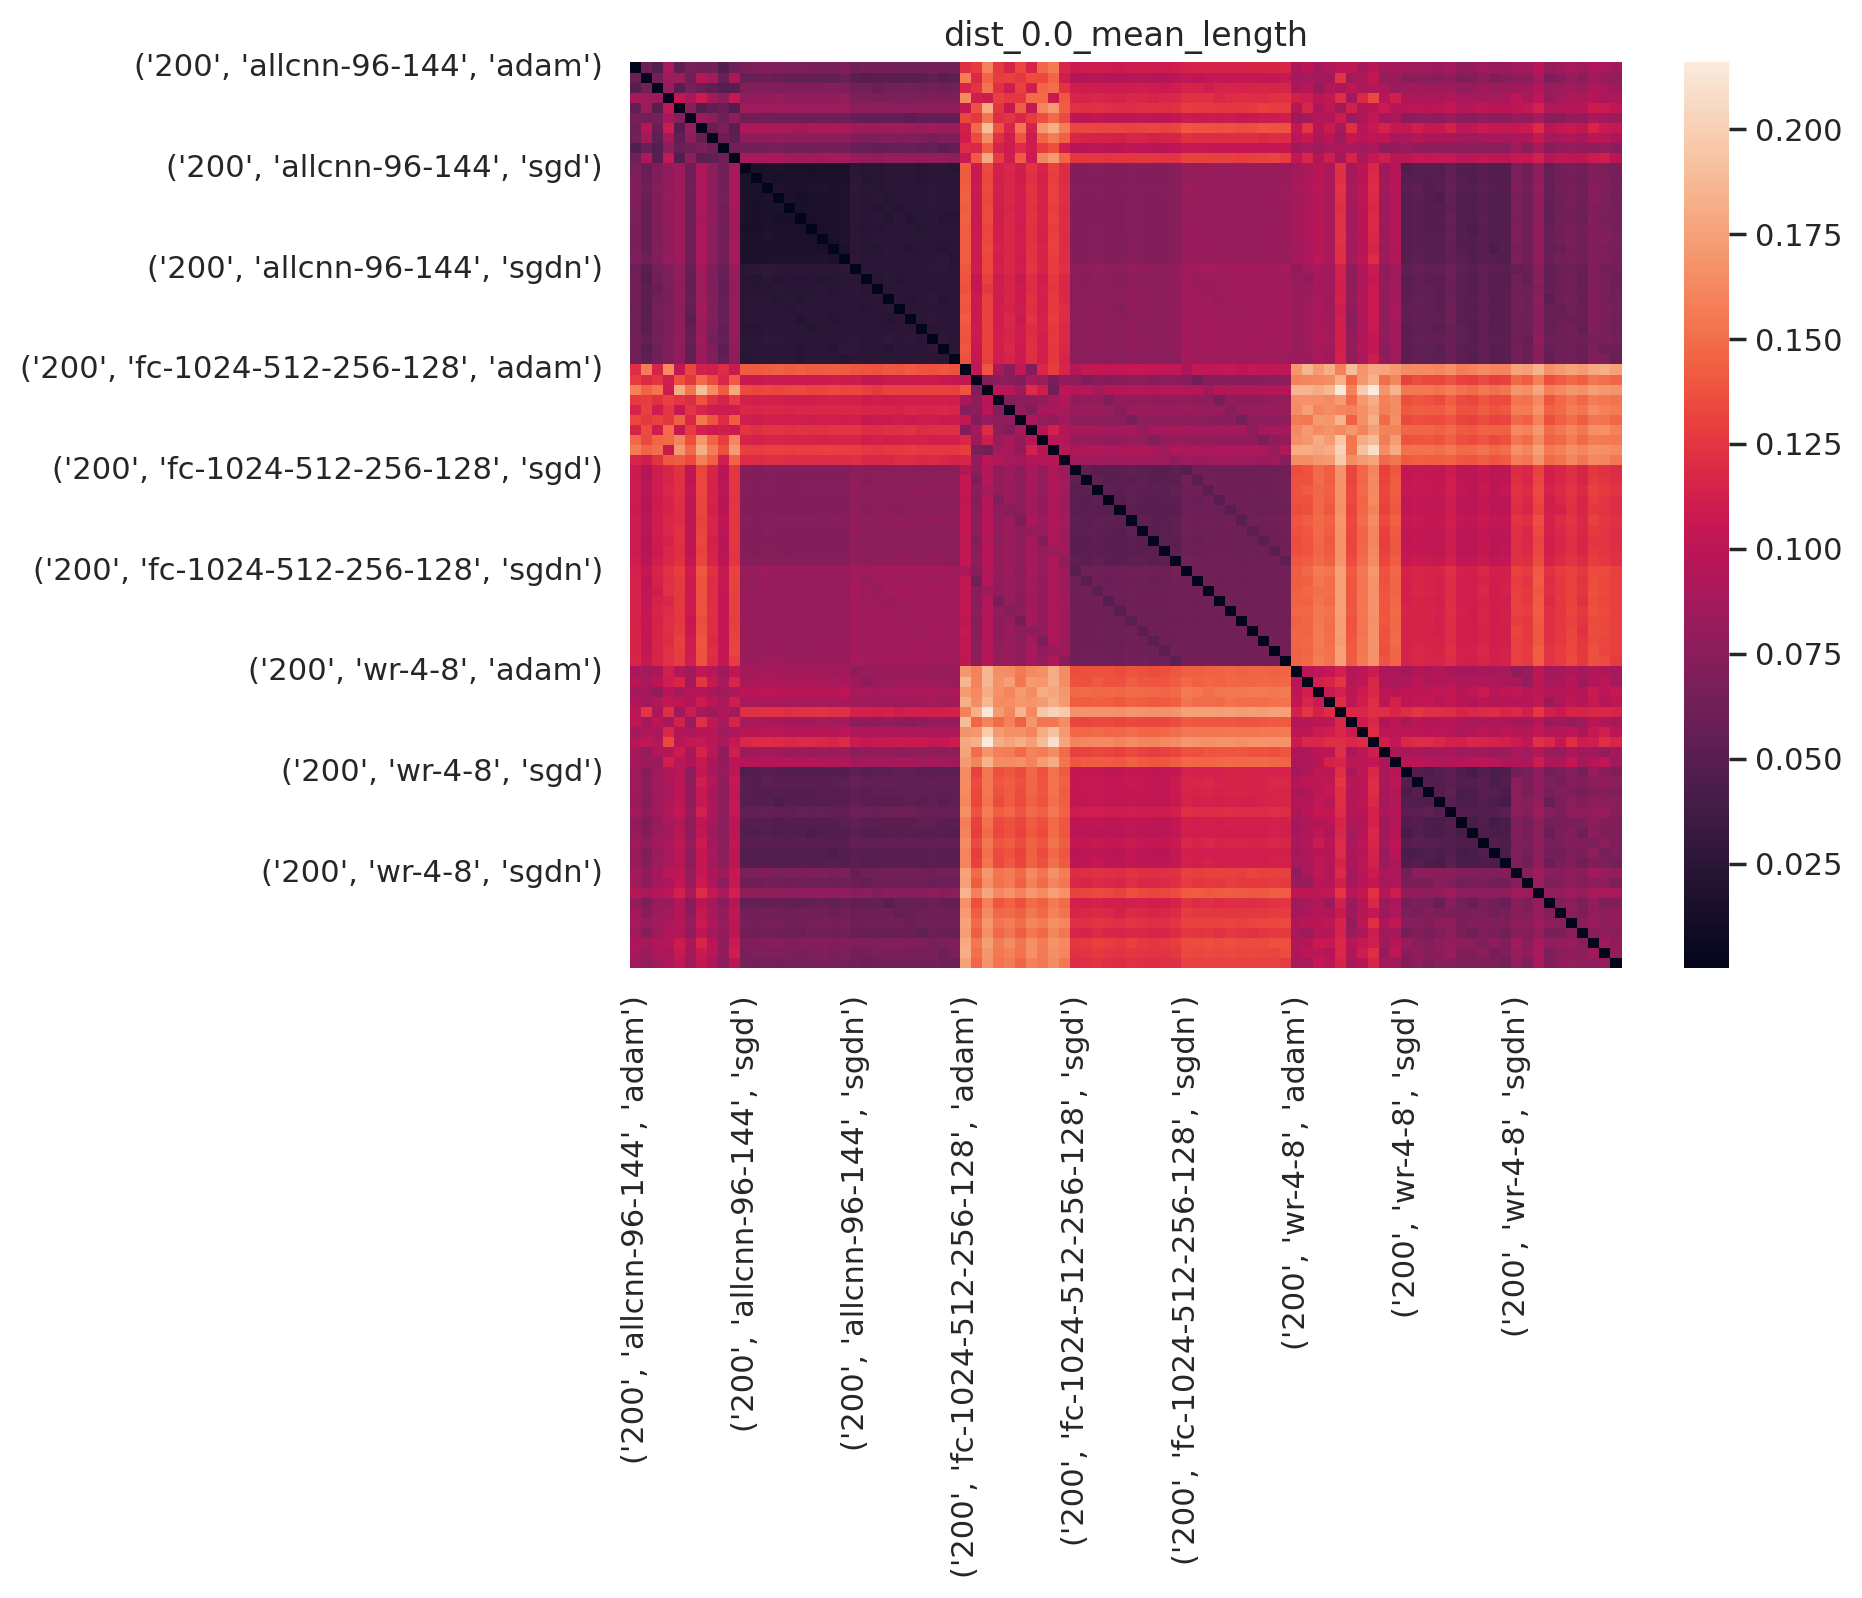

In [23]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length'
dists, symd, configs, groups= th.load(os.path.join(loc, f'{fname}.p')).values()
ax = plot_pairwise_dist(symd, configs, conds={-1:list(range(42,52))}, mean=False, sortby=1, block_size=10, annot=False)
ax.set_title(fname)

Text(0.5, 1.0, 'dist_0.0_mean_length_pdist_mean')

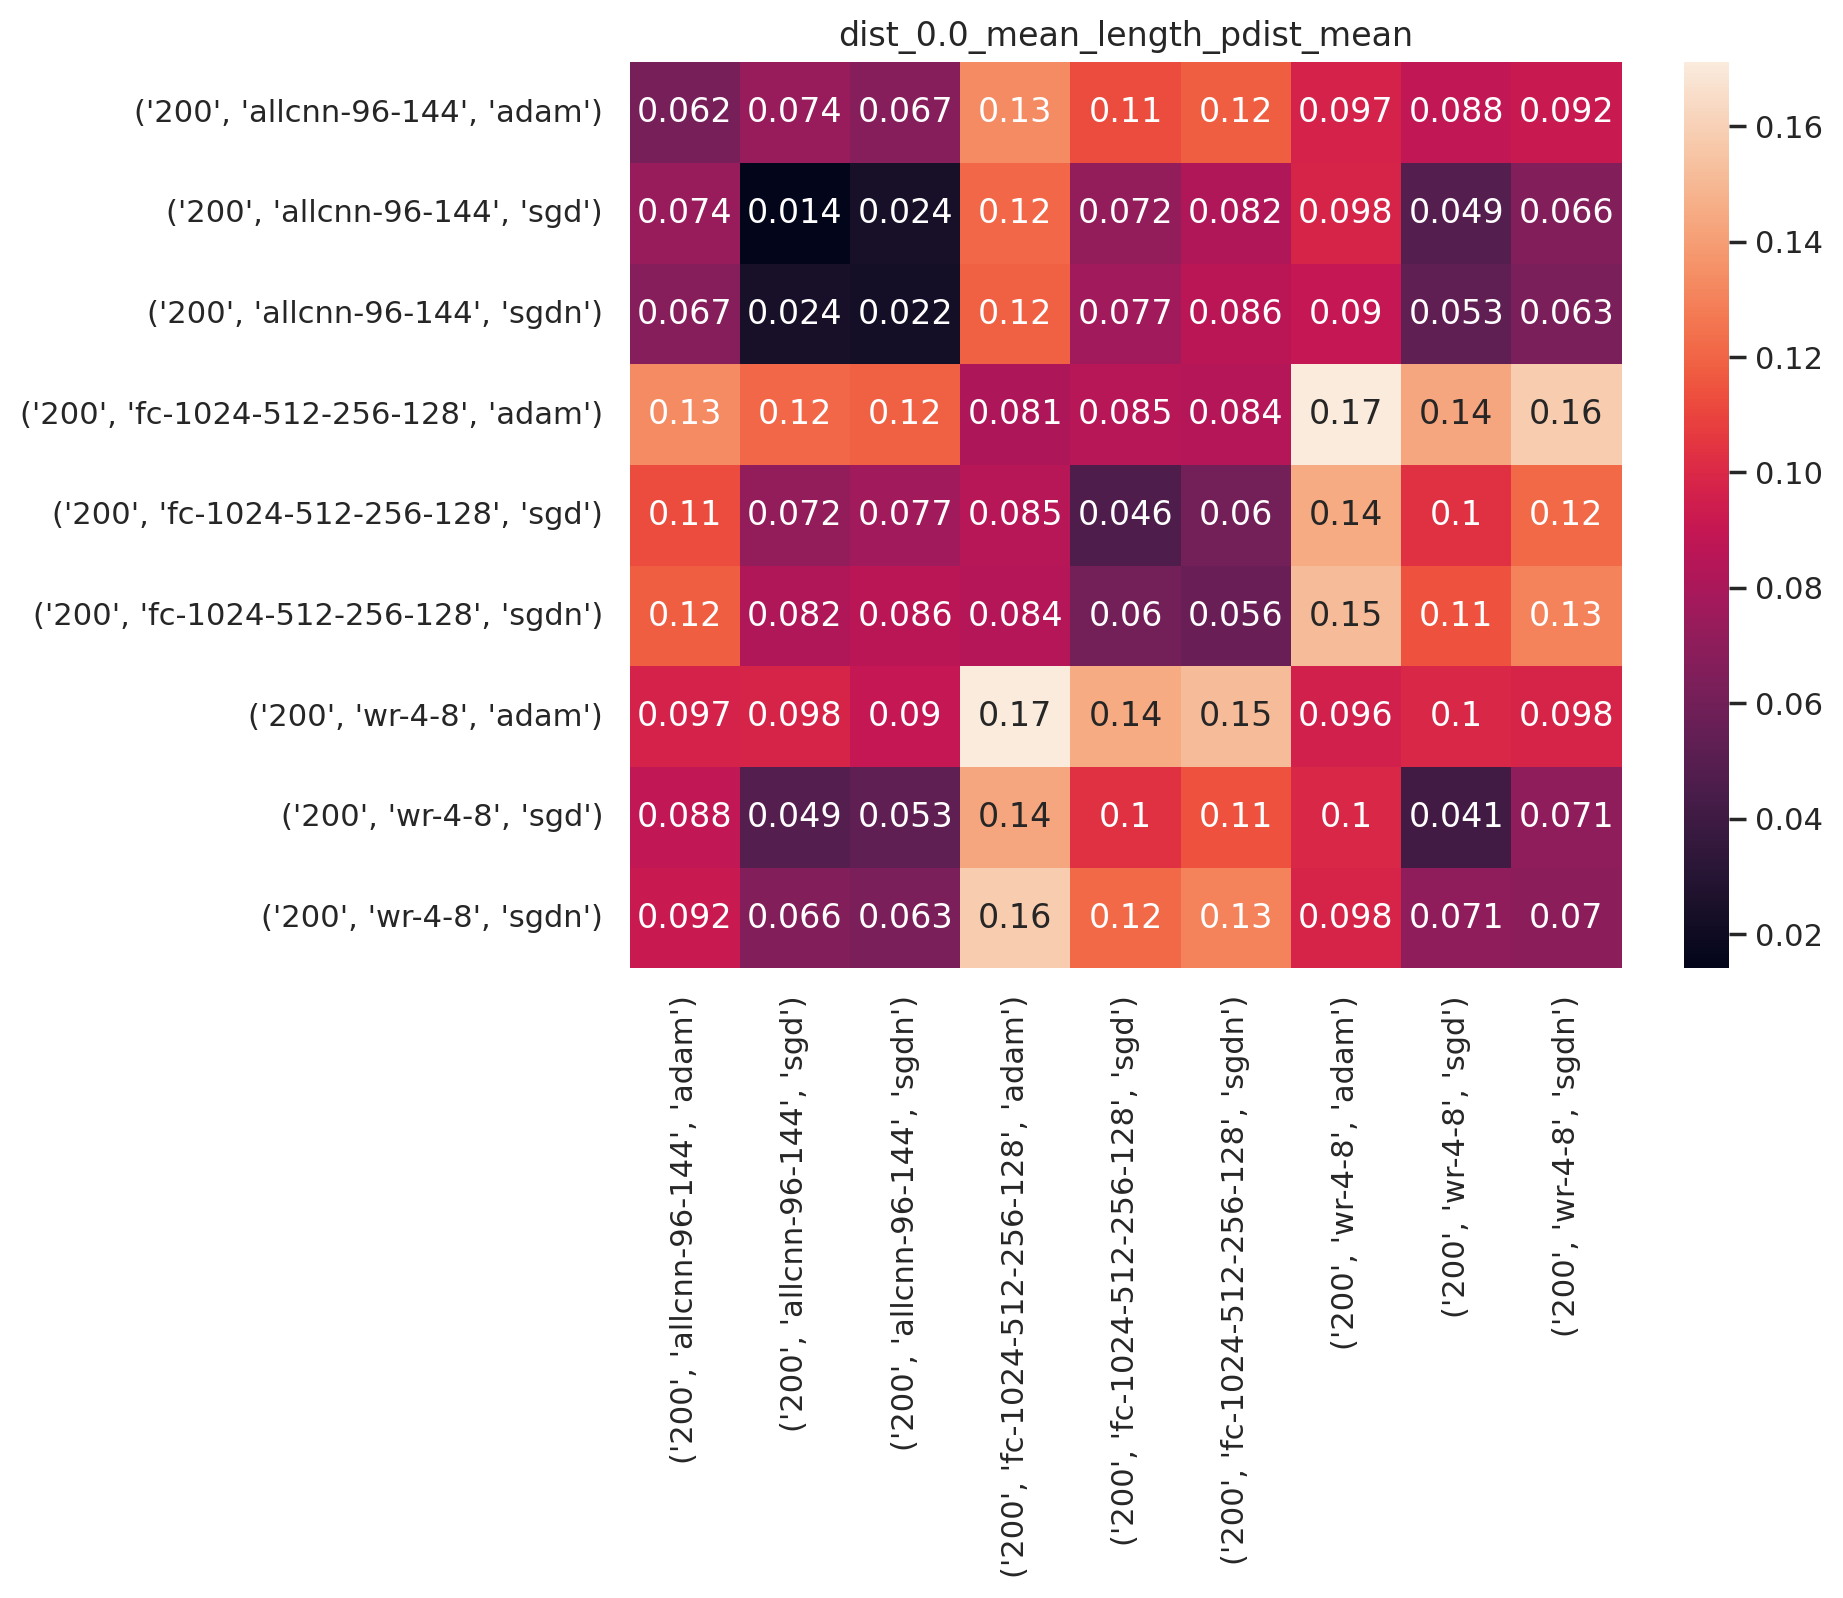

In [43]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length'
dists, symd, configs, groups= th.load(os.path.join(loc, f'{fname}.p')).values()
ax=plot_pairwise_dist(symd, configs, conds={-1:list(range(42,52))}, mean=True, sortby=1, block_size=10, annot=True)
ax.set_title(f"{fname}_pdist_mean")

Text(0.5, 1.0, 'dist_0.0_mean_length_avgm_pdist')

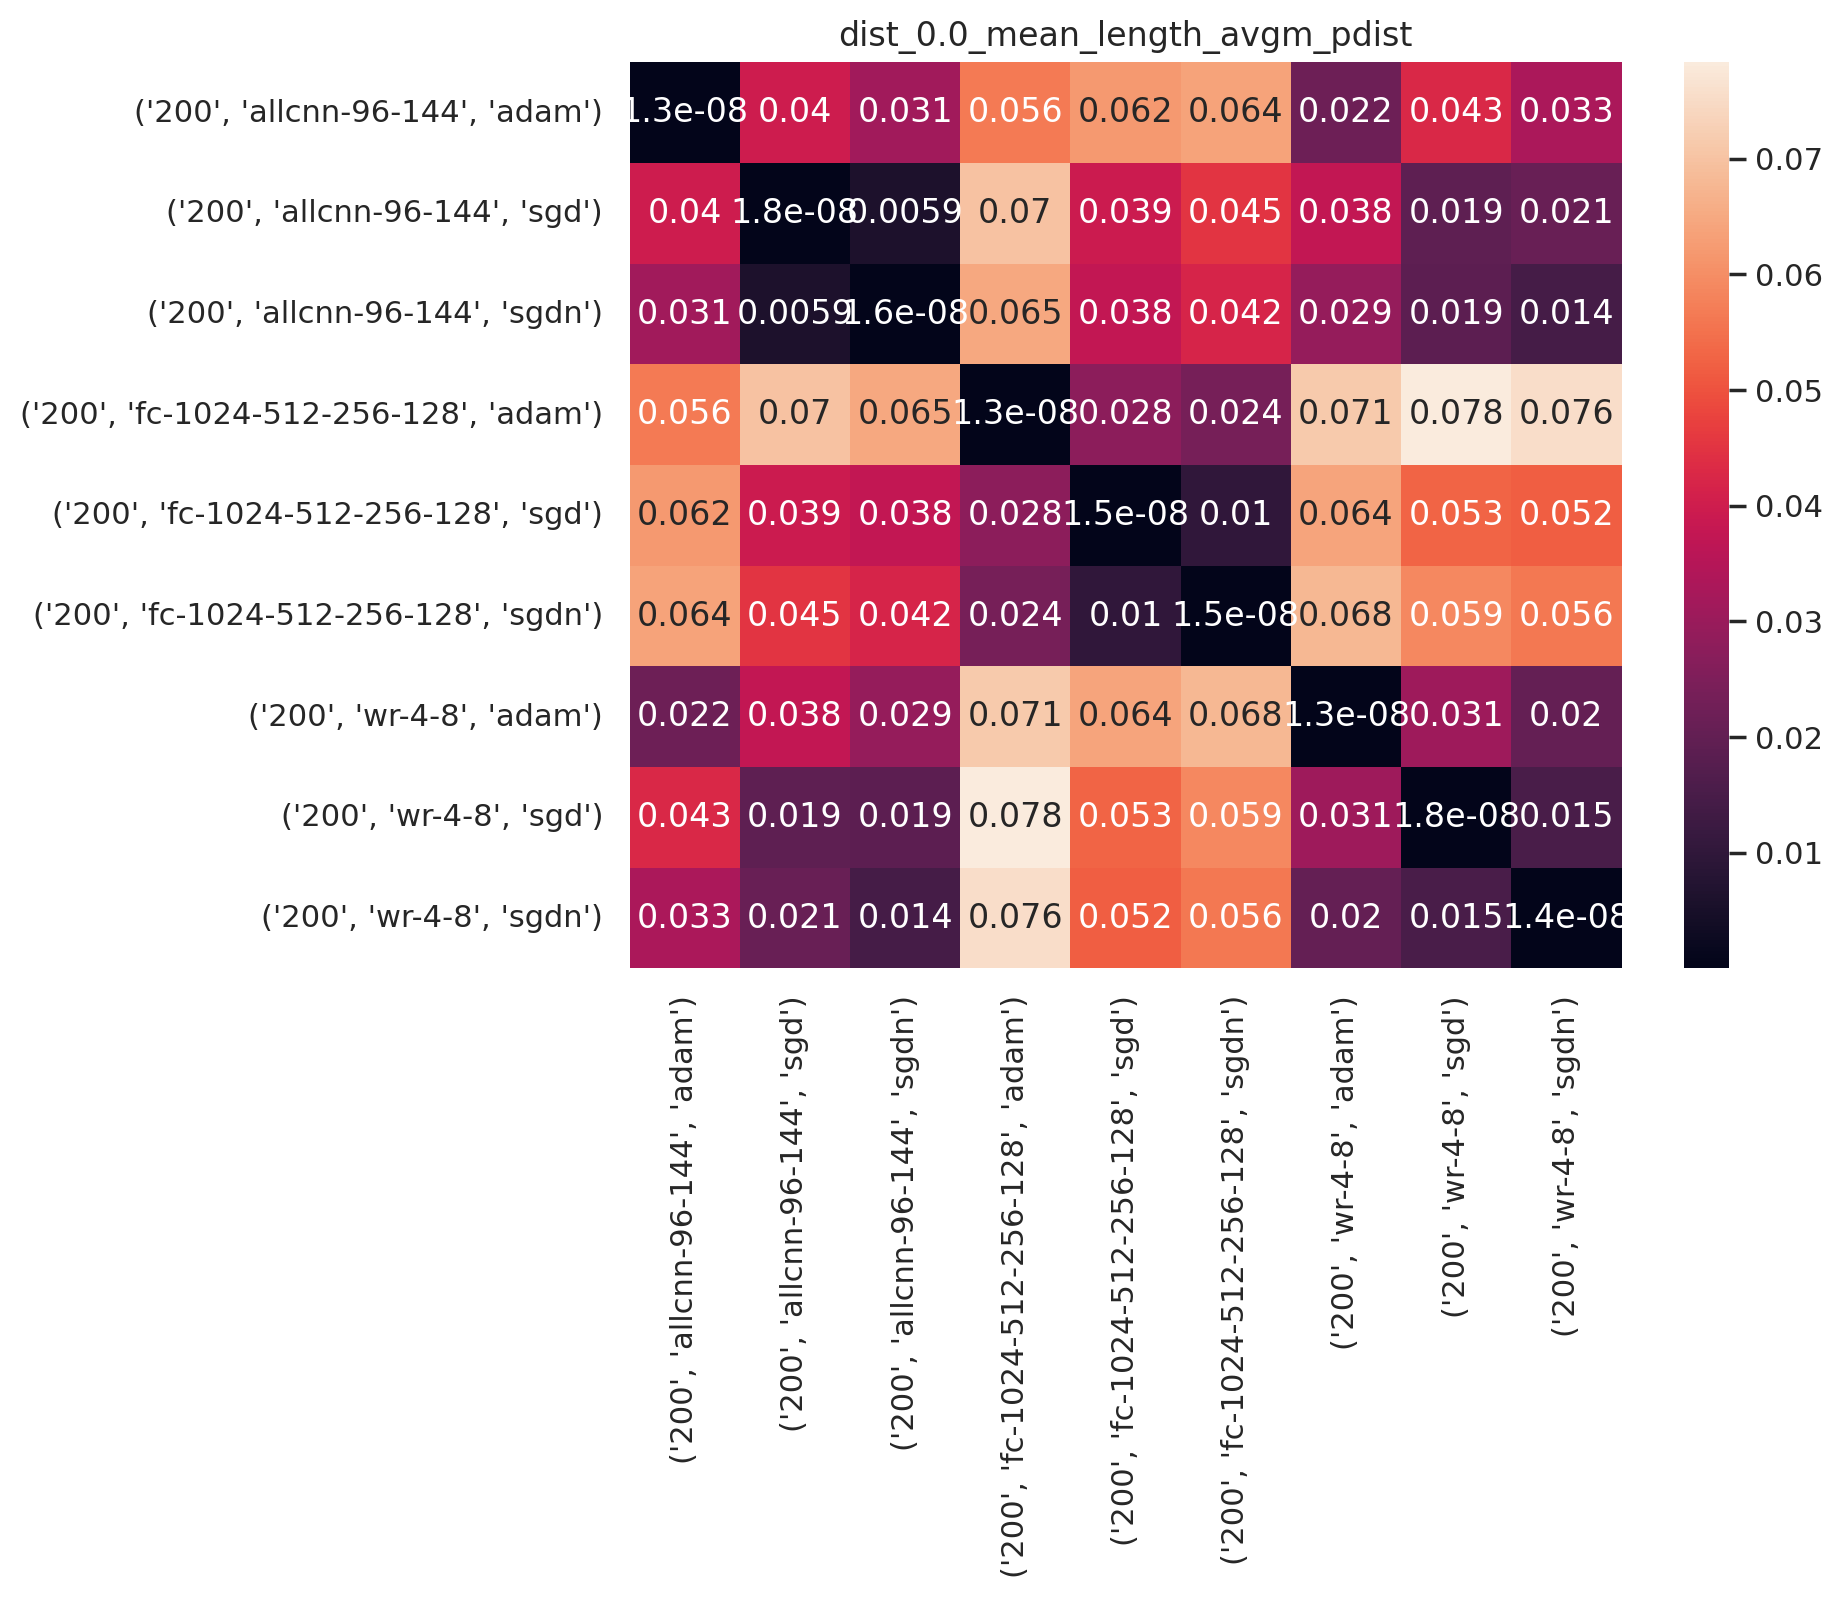

In [42]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length'
dists, symd, configs, groups= th.load(os.path.join(loc, f'{fname}.p')).values()
ax=plot_pairwise_dist(symd, configs, conds={-1:[-1]}, mean=False, sortby=1, block_size=1, annot=True)
ax.set_title(f"{fname}_avgm_pdist")